In [1]:
%reload_ext autoreload
%autoreload 2

In [6]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the MNIST dataset

In [7]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


We can play with it:

(1, 784)


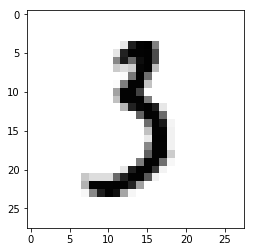

In [20]:
sample_image = mnist.train.next_batch(1)[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

# Definitions

In [82]:
def discriminator(images, reuse=False):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:

        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

In [83]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable(
        'g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='bn1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable(
        'g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='bn2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable(
        'g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='bn3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable(
        'g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)

    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

# Let's try

In [84]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [85]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

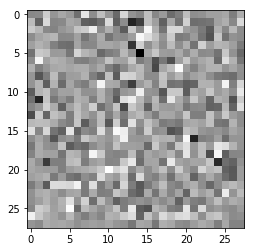

In [86]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

In [87]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape=[None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse=True)
# Dg will hold discriminator prediction probabilities for generated images

In [88]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

In [89]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [90]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_w2:0', 'g_b2:0', 'g_w3:0', 'g_b3:0', 'g_w4:0', 'g_b4:0']


In [91]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

In [93]:
with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
    tf.summary.scalar('Generator_loss', g_loss)
    tf.summary.scalar('Discriminator_loss_real', d_loss_real)
    tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

    images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
    tf.summary.image('Generated_images', images_for_tensorboard, 5)
    merged = tf.summary.merge_all()
    logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
    writer = tf.summary.FileWriter(logdir, sess.graph)

dLossReal: 0.691798 dLossFake: 0.721977
dLossReal: 0.00807455 dLossFake: 0.0388558
dLossReal: 0.000750125 dLossFake: 0.00226194
Iteration: 0 at 2017-12-17 22:19:18.027024


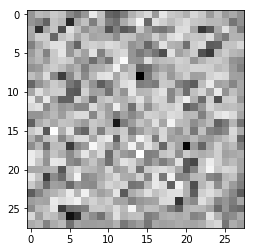

Estimate: [[-6.39027357]]
Iteration: 100 at 2017-12-17 22:20:10.962831


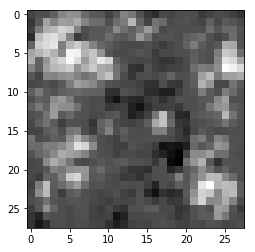

Estimate: [[-5.46297169]]
Iteration: 200 at 2017-12-17 22:21:03.258365


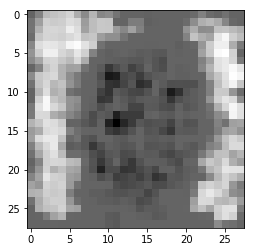

Estimate: [[-12.53047562]]
Iteration: 300 at 2017-12-17 22:21:54.300969


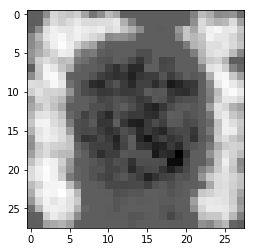

Estimate: [[-11.01969433]]
Iteration: 400 at 2017-12-17 22:22:45.464630


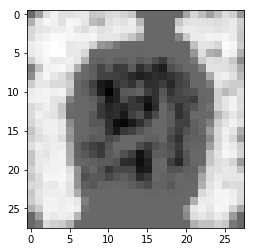

Estimate: [[-9.9051199]]
Iteration: 500 at 2017-12-17 22:23:36.700720


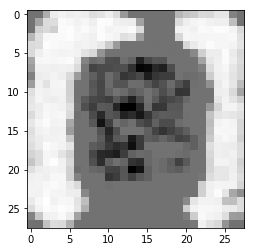

Estimate: [[-10.01181889]]
Iteration: 600 at 2017-12-17 22:24:27.997787


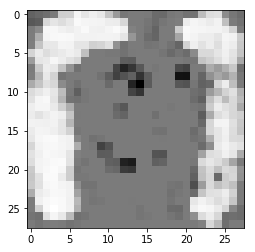

Estimate: [[-14.07459641]]
Iteration: 700 at 2017-12-17 22:25:30.576392


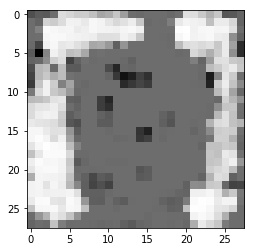

Estimate: [[-16.35283279]]
Iteration: 800 at 2017-12-17 22:26:35.651639


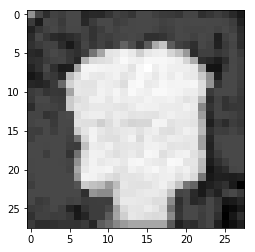

Estimate: [[-27.81894875]]
Iteration: 900 at 2017-12-17 22:27:41.699014


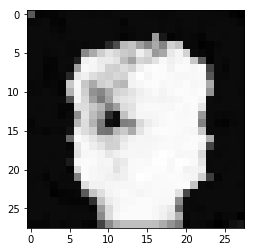

Estimate: [[-26.81954384]]
Iteration: 1000 at 2017-12-17 22:29:30.192275


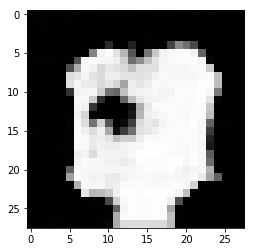

Estimate: [[-25.17636681]]
Iteration: 1100 at 2017-12-17 22:30:47.343446


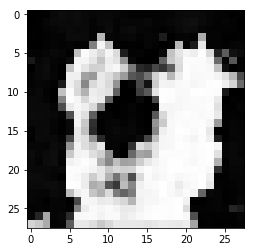

Estimate: [[-22.25183678]]
Iteration: 1200 at 2017-12-17 22:31:47.728714


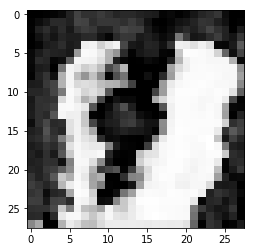

Estimate: [[-19.13539886]]
Iteration: 1300 at 2017-12-17 22:32:48.087633


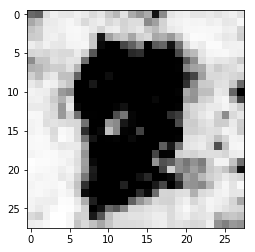

Estimate: [[-12.55738544]]
Iteration: 1400 at 2017-12-17 22:33:51.345159


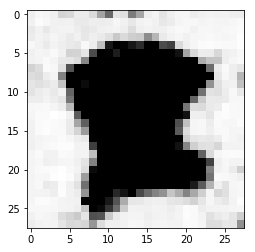

Estimate: [[-6.76399231]]
Iteration: 1500 at 2017-12-17 22:35:30.598939


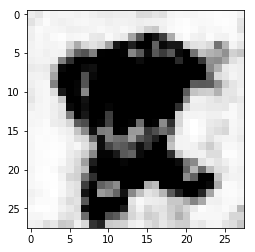

Estimate: [[-10.55009556]]
Iteration: 1600 at 2017-12-17 22:37:05.711405


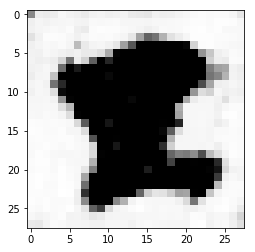

Estimate: [[-10.50453758]]
Iteration: 1700 at 2017-12-17 22:38:20.643658


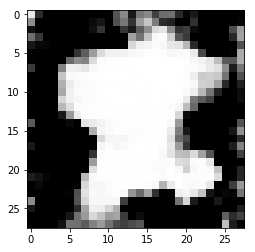

Estimate: [[-7.45618343]]
Iteration: 1800 at 2017-12-17 22:39:24.782110


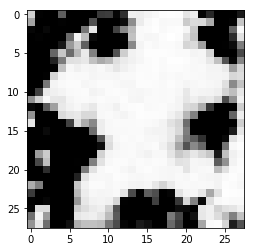

Estimate: [[-13.64984989]]
Iteration: 1900 at 2017-12-17 22:40:23.039485


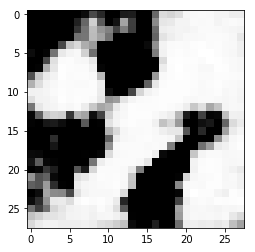

Estimate: [[-9.50875473]]
Iteration: 2000 at 2017-12-17 22:41:23.078228


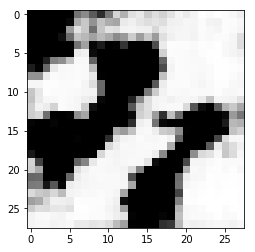

Estimate: [[-8.75572109]]


In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = mnist.train.next_batch(batch_size)[0].reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        with tf.variable_scope(tf.get_variable_scope(), reuse=True) as scope:
            # Every 100 iterations, show a generated image
            print("Iteration:", i, "at", datetime.datetime.now())
            z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
            generated_images = generator(z_placeholder, 1, z_dimensions)
            images = sess.run(generated_images, {z_placeholder: z_batch})
            plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
            plt.show()

            # Show discriminator's estimate
            im = images[0].reshape([1, 28, 28, 1])
            result = discriminator(x_placeholder)
            estimate = sess.run(result, {x_placeholder: im})
            print("Estimate:", estimate)